We work with a dataset containing 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative).  In addition, there are another 50,000 IMDB reviews provided without any rating labels.  

The reviews are split evenly into train and test sets (25k train and 25k test). The overall distribution of labels is also balanced within the train and test sets (12.5k pos and 12.5k neg).  Our ultimate goal is to see how well we can predict sentiment in the test dataset. 

In [1]:
import os                                # accessing directory of files
import pandas as pd                      # storing the data
from bs4 import BeautifulSoup            # removing HTML tags
import re                                # text processing with regular expressions
import nltk.data                         # sentence splitting
import logging                           # output messages for word2vec embedding step
from gensim.models import word2vec       # embedding algorithm
import numpy as np                       # arrays and other mathy structures     
import seaborn as sns                    # pretty plots
from tqdm import tqdm                    # timing algorithms
from sklearn.manifold import TSNE        # reducing embeddings to 2-D
import matplotlib.pyplot as plt, mpld3   # plots
%matplotlib inline                       

# If you are using Python 3, you will get an error.
# (Pattern is a Python 2 library and fails to install for Python 3.)

/Users/alexis/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


The dataset can be downloaded [here](http://ai.stanford.edu/~amaas/data/sentiment/).  We first write code to extract the reviews into Pandas dataframes.  We also record the sentiment of the review, when it is available.

In [2]:
def load_data(directory_name):
    # load dataset from directory to Pandas dataframe
    data = []
    files = [f for f in os.listdir('../../aclImdb/' + directory_name)]
    for f in files:
        with open('../../aclImdb/' + directory_name + f, "r", encoding = 'utf-8') as myfile:
            data.append(myfile.read())
    df = pd.DataFrame({'review': data, 'file': files})
    return df

def add_sentiment(df, sentiment):
    # add sentiment column to Pandas dataframe
    df = df.join(pd.DataFrame({'sentiment': sentiment*np.ones(df.size)}))
    return df

`train_pos`, `train_neg`, `test_pos`, `test_neg`, and `unsup` are Pandas dataframes.  They have either two or three columns, taken from the following potential set of columns:
- `sentiment` $\in \{0,1\}$ : indicates pos (1) or neg (0) sentiment
- `file` : name of file that contains review
- `review` : the full text of the review

In [3]:
# load training dataset
train_pos = load_data('train/pos/')
train_pos = add_sentiment(train_pos, 1)

train_neg = load_data('train/neg/')
train_neg = add_sentiment(train_neg, 0)

# load test dataset
test_pos = load_data('test/pos/')
test_pos = add_sentiment(test_pos, 1)

test_neg = load_data('test/neg/')
test_neg = add_sentiment(test_neg, 0)

# load unsupervised dataset
unsup = load_data('train/unsup/')

Next, we ensure that the dataset was downloaded properly (... technically, not sufficient but necesssary condition ...), by counting the total number of reviews of each type.

In [4]:
print("\n %d pos train reviews \n %d neg train reviews \n %d pos test reviews \n %d neg test reviews \n %d unsup reviews" \
      % (train_pos.shape[0], train_neg.shape[0], test_pos.shape[0], test_neg.shape[0], unsup.shape[0]))
print("\n TOTAL: %d reviews" % int(train_pos.shape[0] + train_neg.shape[0] + test_pos.shape[0] + test_neg.shape[0] + unsup.shape[0]))


 12500 pos train reviews 
 12500 neg train reviews 
 12500 pos test reviews 
 12500 neg test reviews 
 50000 unsup reviews

 TOTAL: 100000 reviews


We need to clean each review, in order to help our algorithm find meaningful relationships between different reviews.  We will convert each review into a list of lists (specifically, a list of sentences, each one a list of words).

Our function `review_to_wordlist` processes each review as follows:
- Punctuation is made consistent through the use of regular expressions.
- HTML tags are removed through the use of the Beautiful Soup library.
- All words are converted to lowercase.
- Each sentence string is converted into a list of words through the use of NLTK's `punkt` tokenizer.

Our function `corpus_to_list` repeatedly applies `review_to_wordlist` to each review in a corpus supplied in the form of a Pandas dataframe.

We note that there is still some room for improvement.  For instance, 
- Strings like "Sgt. Cutter" currently are broken into two sentences.  We should figure out how to differentiate between periods that signify the end of an abbreviation and periods that denote the end of a sentence.
- Some writers separate their sentences with commas or line breaks; the algorithm currently absorbs these multiple sentences into an individual sentence.
- Ellipses are currently processed as multiple, empty sentences (which are then discarded).

Before writing this post, I read the Kaggle tutorial [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors).  My current processing algorithm borrows from that page, but also adds some meaningful improvements, partially informed by the algorithm [here](https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py).  For instance, 
- We keep the punctuation that ends each sentence (i.e., period vs. exclamation point), whereas punctuation was discarded in the Kaggle tutorial.  
- Smarter processing of contractions, in a way that understands that "should've" = "should" + "'ve", for instance, could also prove useful for language understanding.

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def clean_str(string):
    # Function that cleans text using regular expressions
    string = re.sub(r' +', ' ', string)
    string = re.sub(r'\.+', '.', string)
    string = re.sub(r'\.(?! )', '. ', string)    
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'m", " \'m", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " ( ", string) 
    string = re.sub(r"\)", " ) ", string) 
    string = re.sub(r"\?", " ? ", string) 
    string = re.sub(r"\.", " . ", string)
    string = re.sub(r"\-", " - ", string)
    string = re.sub(r"\;", " ; ", string)
    string = re.sub(r"\:", " : ", string)
    string = re.sub(r'\"', ' " ', string)
    string = re.sub(r'\/', ' / ', string)
    return string

def review_to_word_list( review, tokenizer ):
    #
    # Function to turn each review into a list of sentences, 
    # where each sentence is a list of words
    #
    # 1. Process punctuation, excessive periods, missing spaces 
    review = clean_str(review)
    #
    # 2. Remove HTML tags 
    review = BeautifulSoup(review, "lxml").get_text()
    #
    # 3. Use the NLTK tokenizer to split the review into list of sentences
    #   (getting rid of extra spaces at front/back)
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 4. Loop over each sentence to get list of list of lowercase words
    sentences = []
    for raw_sentence in raw_sentences:
        # Convert to lowercase and split into list of words
        raw_sentence = raw_sentence.lower().split()
        # If a sentence is not long enough, skip it
        if len(raw_sentence) > 1:
            # add list of words to returned object
            sentences.append( raw_sentence )
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [6]:
def corpus_to_list(df, tokenizer):
    # Turns dataframe of reviews into a list of sentences,
    # where each sentence is a list of words
    # and sentences are derived from *all reviews* in dataframe df
    sentences = []
    for idx in tqdm(df.index):
        to_append = review_to_word_list(df.ix[idx, 'review'], tokenizer)
        sentences += to_append
    return sentences

We pass each Pandas dataframe through `corpus_to_list` to get corresponding lists of lists of words.

In [7]:
train_pos_sentences = corpus_to_list(train_pos, tokenizer)
train_neg_sentences = corpus_to_list(train_neg, tokenizer)
test_pos_sentences = corpus_to_list(test_pos, tokenizer)
test_neg_sentences = corpus_to_list(test_neg, tokenizer)
unsup_sentences = corpus_to_list(unsup, tokenizer)

100%|██████████| 50000/50000 [00:50<00:00, 998.34it/s]


We next identify the lengths of the longest and shortest sentences in each collection.

In [8]:
def extreme_sentences(sentences):
    # prints shortest and longest sentence in a list (sentences)
    (tmp, longest_sentence) = max(enumerate(sentences), key = lambda sentences: len(sentences[1]))   
    (tmp, shortest_sentence) = min(enumerate(sentences), key = lambda sentences: len(sentences[1]))
    print("The longest sentence has %s words." % len(longest_sentence))
    print("The shortest sentence has %s words." % len(shortest_sentence))
    print(longest_sentence)
    print("Shortest sentence:", shortest_sentence, '\n')

In [9]:
all_sentences = ['train_pos_sentences', 'train_neg_sentences', 'test_pos_sentences', 'test_neg_sentences', 'unsup_sentences']
for i in all_sentences:
    print("Extreme sentence statistics for " + i + ":")
    extreme_sentences(eval(i))

Extreme sentence statistics for train_pos_sentences:
The longest sentence has 278 words.
The shortest sentence has 2 words.
['it', "'s", 'a', 'genuine', 'shame', 'that', 'this', 'spin', '-', 'off', 'tv', 'series', 'inspired', 'by', 'the', 'superior', 'made', '-', 'for', '-', 'tv', 'pictures', '"', 'the', 'night', 'stalker', '"', 'and', '"', 'the', 'night', 'strangler', '"', 'only', 'lasted', 'a', 'single', 'season', 'and', 'twenty', 'episodes', ',', 'because', 'at', 'its', 'best', 'this', 'program', 'offered', 'an', 'often', 'winning', 'and', 'highly', 'entertaining', 'blend', 'of', 'sharp', 'cynical', 'humor', '(', 'carl', 'kolchak', "'s", 'spirited', 'verbal', 'sparring', 'matches', 'with', 'perpetually', 'irascible', 'and', 'long', '-', 'suffering', 'editor', 'tony', 'vincenzo', 'were', 'always', 'a', 'treat', 'to', 'watch', 'and', 'hear', ')', ',', 'clever', 'writing', ',', 'nifty', 'supernatural', 'menaces', '(', 'gotta', 'love', 'the', 'offbeat', 'and', 'original', 'creatures', '

To gain some additional understanding of our corpus, we investigate the distribution of sentence lengths more closely.

Total number of sentences: 1325240
Sentences of length 0: 34865
Sentences of length >200: 79 ( 0.005961184389242704 %,  <=200: 1325161 )

Sentences of length >100: 1752 ( 0.13220246898674956 %,  <=100: 1323488 )

Sentences of length >60: 19585 ( 1.4778455223204854 %,  <=60: 1305655 )



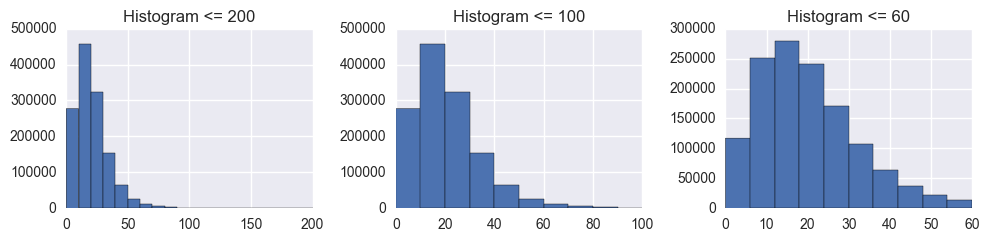

In [10]:
# obtain list of sentence lengths
sentences = train_pos_sentences + train_neg_sentences + test_pos_sentences + test_neg_sentences + unsup_sentences
sentence_lengths = [len(elem) for elem in sentences]
sentence_lengths.sort()

# get total number of sentences
print("Total number of sentences:", len(sentence_lengths))
# get number of sentences of length 2
print("Sentences of length 0:", sum([i==2 for i in sentence_lengths]))
# get number of sentences of size greater than 200
print("Sentences of length >200:", sum([i>200 for i in sentence_lengths]), 
      "(", 100*sum([i>200 for i in sentence_lengths])/len(sentence_lengths), "%, ",
      "<=200:", sum([i<=200 for i in sentence_lengths]), ")\n")
# get number of sentences of size greater than 100
print("Sentences of length >100:", sum([i>100 for i in sentence_lengths]),
      "(", 100*sum([i>100 for i in sentence_lengths])/len(sentence_lengths), "%, ",
      "<=100:", sum([i<=100 for i in sentence_lengths]), ")\n")
# get number of sentences of size greater than 60
print("Sentences of length >60:", sum([i>60 for i in sentence_lengths]), 
      "(", 100*sum([i>60 for i in sentence_lengths])/len(sentence_lengths), "%, ",
      "<=60:", sum([i<=60 for i in sentence_lengths]), ")\n")

# make plots
plt.figure(figsize=(10,2.5))

# make histogram of sentence lengths for sentences <=200 
plt.subplot(131)
plt.hist(sentence_lengths, bins=np.linspace(0, 200, 21))
plt.title("Histogram <= 200")

# make histogram of sentence lengths for sentences <=100 
plt.subplot(132)
plt.hist(sentence_lengths, bins=np.linspace(0, 100, 11))
plt.title("Histogram <= 100")

# make histogram of sentence lengths for sentences <=60
plt.subplot(133)
plt.hist(sentence_lengths, bins=np.linspace(0, 60, 11))
plt.title("Histogram <= 60")

# adjust spacing between subplots to minimize the overlaps
plt.tight_layout()
plt.show()

Next, we train the Word2Vec model.

In [11]:
# Uncomment the below line to visualize progress
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model 
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

To peek at how the Word2Vec embedding might be working, we output the words that are deemed closest to a couple of sentiment-charged words.

In [12]:
model.most_similar("awesome")

[('amazing', 0.7369562983512878),
 ('incredible', 0.7106951475143433),
 ('fantastic', 0.6842675805091858),
 ('excellent', 0.6620400547981262),
 ('outstanding', 0.632002592086792),
 ('astounding', 0.6208924055099487),
 ('exceptional', 0.6207690238952637),
 ('fabulous', 0.6073384881019592),
 ('cool', 0.6014707088470459),
 ('alright', 0.5790180563926697)]

In [13]:
model.most_similar("awful")

[('atrocious', 0.7555239796638489),
 ('terrible', 0.7463086843490601),
 ('dreadful', 0.7156774997711182),
 ('abysmal', 0.7071986794471741),
 ('horrible', 0.7011712789535522),
 ('appalling', 0.6923713684082031),
 ('horrendous', 0.6786303520202637),
 ('horrid', 0.6656671762466431),
 ('lousy', 0.6165692806243896),
 ('bad', 0.5991725921630859)]

We next use the TSNE algorithm to visualize a subset of the words in a lower-dimensional embedding.  It should be possible to zoom into the plot below.  (On my end, plot is broken in Firefox, but works just fine in Safari!)

In [14]:
upper_limit = 300

vocabulary = list(model.vocab.keys())[:upper_limit]
emb_tuple = tuple([model[v] for v in vocabulary])
X = np.vstack(emb_tuple)
tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
X_new = tsne_model.fit_transform(X) 

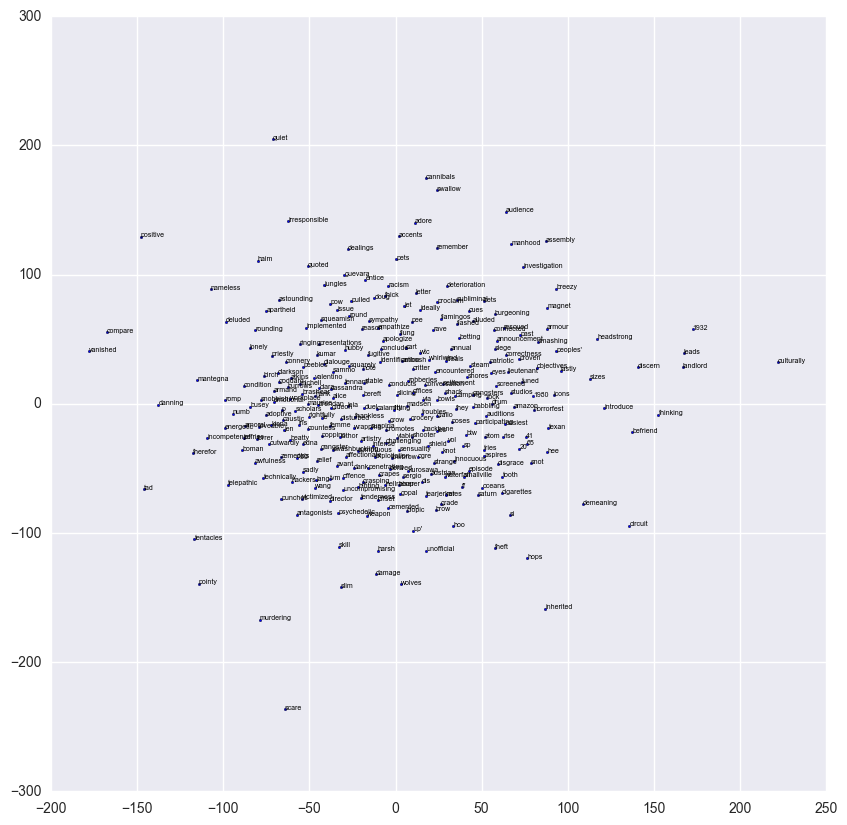

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(X_new[:, 0], X_new[:, 1], s=3)
for label, x, y in zip(vocabulary, X_new[:, 0], X_new[:, 1]):
    plt.text(x, y, label, {'color': 'k', 'fontsize': 5})
mpld3.enable_notebook()

TODO: Use embeddings to perform sentiment analysis.